In [ ]:
ABSOLUTE READ COUNTS

In [2]:
import glob
import pandas as pd

# Find all baked_phage CSVs
files = glob.glob("input_oligos*.csv")
if not files:
    raise FileNotFoundError("No baked_phage*.csv files found in this directory.")

# Initialize an empty DataFrame
combined = pd.DataFrame()

# Read each file and merge
for f in files:
    df = pd.read_csv(f, header=None, names=["peptide", "count"])
    if combined.empty:
        combined = df
    else:
        # merge on peptide name, fill missing counts with 0
        combined = pd.merge(combined, df, on="peptide", how="outer", suffixes=("", "_tmp")).fillna(0)
        # sum across duplicate columns
        count_cols = [col for col in combined.columns if col.startswith("count")]
        combined["count"] = combined[count_cols].sum(axis=1)
        # drop extra columns
        combined = combined[["peptide", "count"]]

# Save summed results
combined.to_csv("summed_input_oligos_peptide_counts.csv", index=False)

print("Saved summed counts to summed_peptide_counts.csv")


Saved summed counts to summed_peptide_counts.csv


In [14]:
import pandas as pd

df = pd.read_csv("summed_peptide_counts_baked_phage.csv")

# total library size
library_size = 90128  

# peptides detected (≥1 read)
detected = (df["count"] > 0).sum()

# representation fraction
fraction = detected / library_size

print(f"Detected peptides: {detected:,} / {library_size:,}")
print(f"Representation: {fraction:.2%}")


Detected peptides: 89,869 / 90,128
Representation: 99.71%


5th percentile: 32.00
95th percentile: 83.00


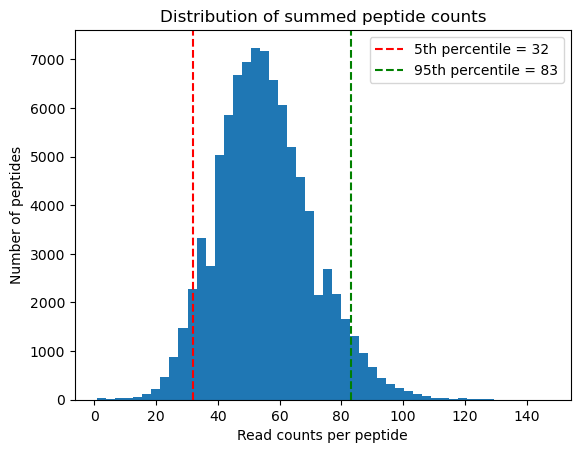

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("summed_input_oligos_peptide_counts.csv")
counts = df["count"]

# Compute 5th and 95th percentiles
p5 = np.percentile(counts, 5)
p95 = np.percentile(counts, 95)

print(f"5th percentile: {p5:.2f}")
print(f"95th percentile: {p95:.2f}")

plt.hist(counts, bins=50)
plt.xlabel("Read counts per peptide")
plt.ylabel("Number of peptides")
plt.title("Distribution of summed peptide counts")
# Add percentile lines
plt.axvline(p5, color="red", linestyle="--", label=f"5th percentile = {p5:.0f}")
plt.axvline(p95, color="green", linestyle="--", label=f"95th percentile = {p95:.0f}")

plt.legend()
plt.savefig("summed_counts_histogram_with_percentiles.png", dpi=300)
plt.show()



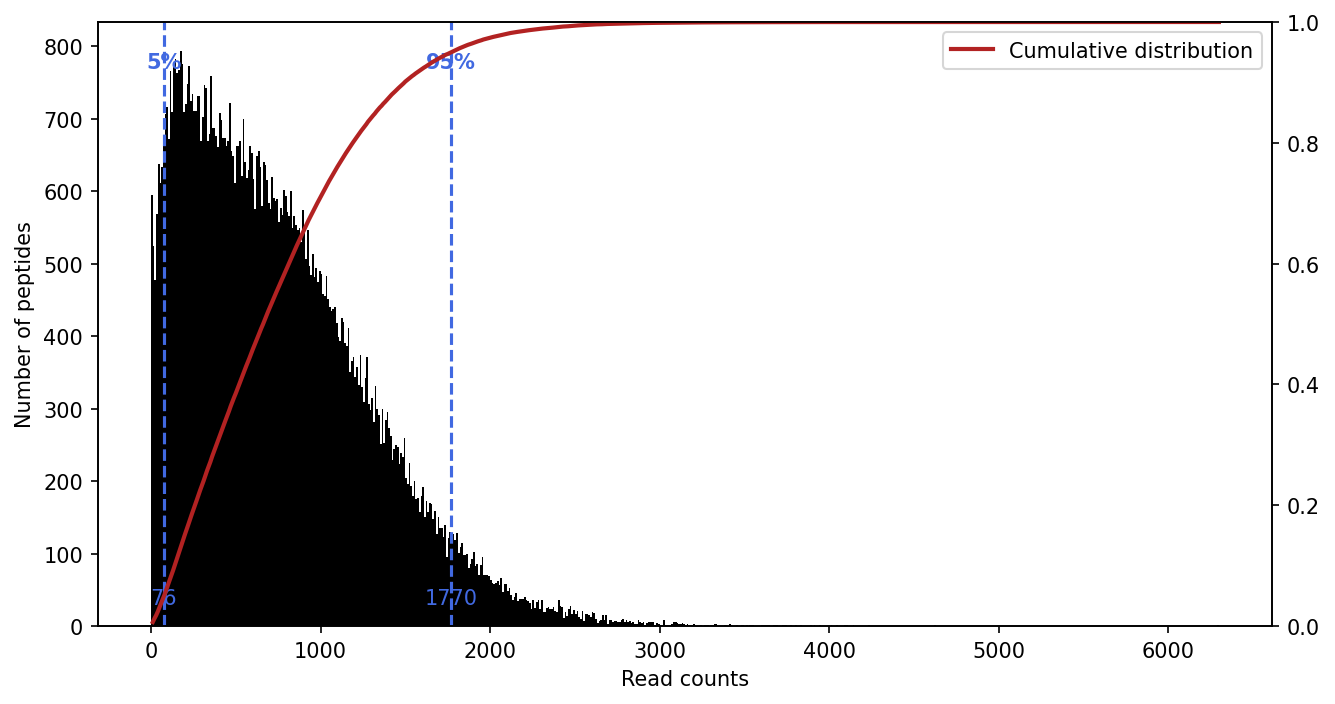

5th percentile:  76.00
95th percentile: 1770.00


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- load your counts ---
# If you already have a Series called `counts`, skip the next two lines.
df = pd.read_csv("summed_peptide_counts_baked_phage.csv")  # change to your file
counts = df["count"].to_numpy()                            # change column name if needed

# --- percentiles ---
p5  = np.percentile(counts, 5)
p95 = np.percentile(counts, 95)

# --- histogram bins (tweak binwidth if you want smoother/rougher bars) ---
binwidth = 10
bins = np.arange(0, counts.max() + binwidth, binwidth)

hist, edges = np.histogram(counts, bins=bins)
centers = 0.5 * (edges[:-1] + edges[1:])
widths  = np.diff(edges)

# --- cumulative distribution (empirical CDF from the histogram) ---
cdf = np.cumsum(hist) / hist.sum()

# --- plot ---
fig, ax = plt.subplots(figsize=(9,4.8), dpi=150)

# histogram (black bars)
ax.bar(centers, hist, width=widths, align="center", color="black")

ax.set_xlabel("Read counts")
ax.set_ylabel("Number of peptides")

# secondary axis for CDF (red curve)
ax2 = ax.twinx()
ax2.plot(edges[1:], cdf, lw=2, color="firebrick", label="Cumulative distribution")
ax2.set_ylim(0, 1)
ax2.set_ylabel("")  # optional
ax2.legend(loc="upper right")

# percentile lines & labels (blue)
def annotate_percentile(x, label):
    ax.axvline(x, color="royalblue", ls="--", lw=1.5)
    # "5%" / "95%" near the top
    ymax = ax.get_ylim()[1]
    ax.text(x, ymax*0.95, label, color="royalblue", fontweight="bold",
            ha="center", va="top")
    # numeric value near the bottom
    ymin = ax.get_ylim()[0]
    ax.text(x, ymin + (ymax - ymin)*0.03, f"{int(round(x))}",
            color="royalblue", ha="center", va="bottom")

annotate_percentile(p5,  "5%")
annotate_percentile(p95, "95%")

plt.tight_layout()
plt.show()

print(f"5th percentile:  {p5:.2f}")
print(f"95th percentile: {p95:.2f}")


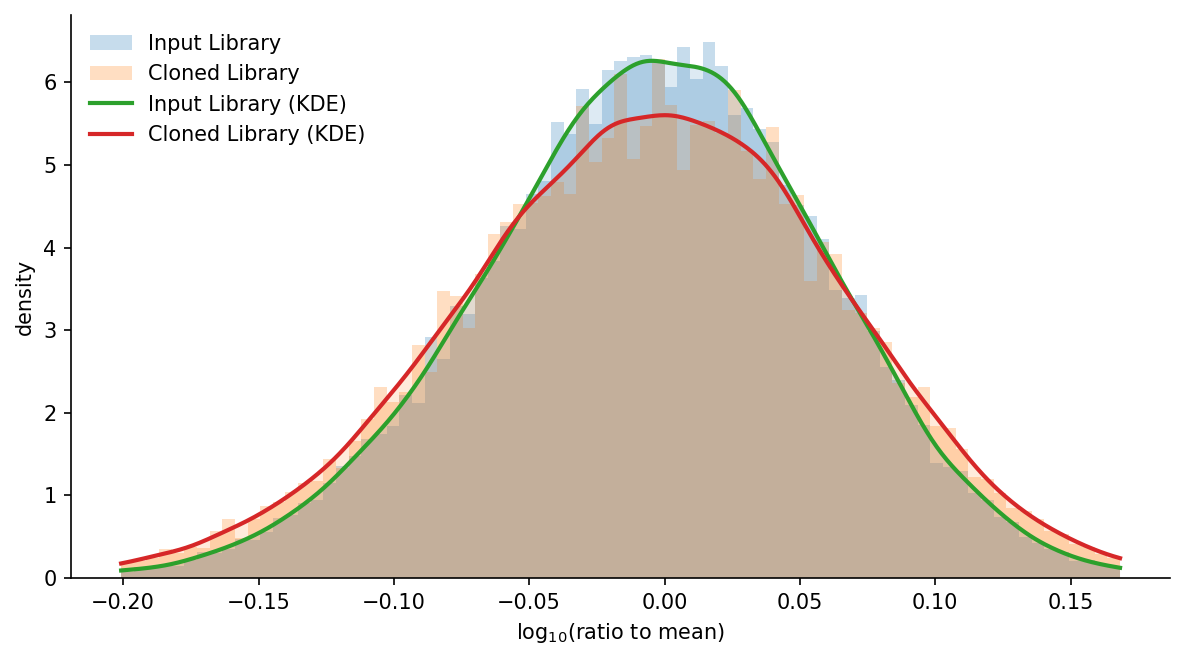

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Load your two count vectors ----
# Replace these with your files/columns
df_in  = pd.read_csv("summed_input_oligos_peptide_counts.csv")
df_cl  = pd.read_csv("summed_peptide_counts_baked_phage.csv")
counts_input  = df_in["count"].to_numpy()
counts_cloned = df_cl["count"].to_numpy()

# Demo placeholders (delete when using real data):
counts_input  = np.random.negative_binomial(50, 0.05, size=50000)
counts_cloned = np.random.negative_binomial(40, 0.06, size=50000)

# ---- Transform to log10(ratio to mean) ----
def log_ratio_to_mean(x):
    x = np.asarray(x, dtype=float)
    m = np.mean(x)
    # add a tiny epsilon so zeros don’t blow up the log
    return np.log10((x + 1e-9) / (m + 1e-9))

x_in  = log_ratio_to_mean(counts_input)
x_cl  = log_ratio_to_mean(counts_cloned)

# ---- Simple Gaussian KDE (no SciPy dependency) ----
def kde_1d(x, grid, bandwidth=None):
    x = x.ravel()
    if bandwidth is None:
        # Silverman’s rule-of-thumb
        std = np.std(x, ddof=1)
        n   = len(x)
        bandwidth = 1.06 * std * n ** (-1/5)
        if bandwidth <= 0:
            bandwidth = 0.1
    # compute kernel density
    # (grid[:,None] - x[None,:])^2 -> distances, Gaussian kernel
    d2 = (grid[:, None] - x[None, :])**2
    k  = np.exp(-0.5 * d2 / (bandwidth**2)) / (np.sqrt(2*np.pi) * bandwidth)
    # average over samples to get density; normalize to integrate ~1
    dens = k.mean(axis=1)
    # numerical normalization to make it a proper density
    dx = np.diff(grid).mean()
    dens = dens / (np.sum(dens) * dx)
    return dens

# ---- Common grid for plotting ----
xmin = min(np.percentile(x_in,  0.5), np.percentile(x_cl,  0.5))
xmax = max(np.percentile(x_in, 99.5), np.percentile(x_cl, 99.5))
grid = np.linspace(xmin, xmax, 600)

dens_in = kde_1d(x_in, grid)
dens_cl = kde_1d(x_cl, grid)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Overlaid histograms as densities (transparent)
bins = np.linspace(xmin, xmax, 80)
ax.hist(x_in, bins=bins, density=True, alpha=0.25, label="Input Library")
ax.hist(x_cl, bins=bins, density=True, alpha=0.25, label="Cloned Library")

# Smooth KDE curves + light fills
ax.plot(grid, dens_in, linewidth=2, label="Input Library (KDE)")
ax.fill_between(grid, dens_in, alpha=0.15)
ax.plot(grid, dens_cl, linewidth=2, label="Cloned Library (KDE)")
ax.fill_between(grid, dens_cl, alpha=0.15)

# Cosmetics
ax.set_xlabel("log$_{10}$(ratio to mean)")
ax.set_ylabel("density")
ax.legend(loc="upper left", frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


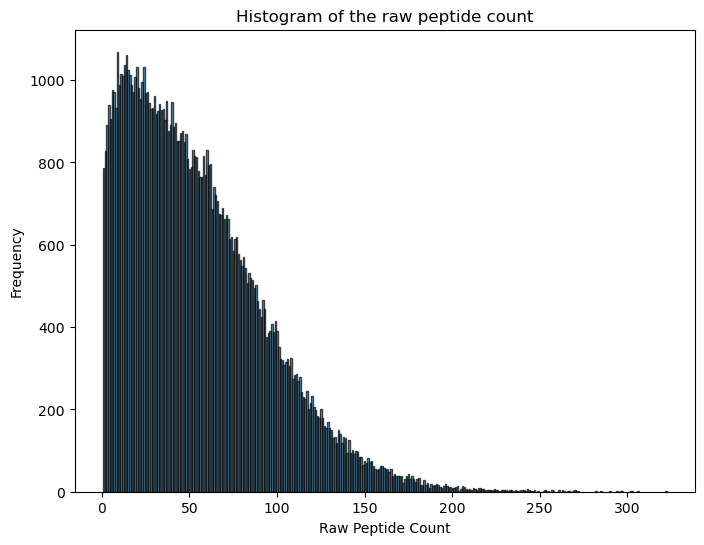

In [10]:
#convert the raw peptide count stats you get form phagedb to a histogram 

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv("/Users/sophieporak/Downloads/baked_phage_F4_S4_R1_001.csv")

col = pd.to_numeric(df.iloc[:, 1], errors="coerce").dropna().astype(int)

freq = col.value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(freq.index, freq.values, edgecolor="black", alpha=0.7)
plt.xlabel("Raw Peptide Count")
plt.ylabel("Frequency")
plt.title("Histogram of the raw peptide count")
plt.show()